## Engenharia de Sistemas de Software Inteligentes - Profs. Marcos Kalinowski e Tatiana Escovedo
## Aula 02: Prática de Machine Learning em Python

In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pickle import dump
from pickle import load

## Carga do Dataset

In [21]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/rodnav08/MVP_04/main/database/database_YT.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=';')

le = LabelEncoder()
dataset['Country'] = le.fit_transform(dataset['Country'])
dataset['Category'] = le.fit_transform(dataset['Category'])



# Mostra as primeiras linhas do dataset
dataset.head()

,subscribers,video views,uploads,Country,Category,video_views_for_the_last_30_days,highest_monthly_earnings,Pay well
0,245000000,228000000000,20082,19,8,2258000000,9000000,1
1,166000000,28368841870,741,47,4,1348000000,5400000,1
2,162000000,164000000000,966,47,3,1975000000,7900000,1
3,159000000,148000000000,116536,19,4,1824000000,7300000,1
4,112000000,93247040539,1111,47,4,731674000,2900000,1


## Separação em conjunto de treino e conjunto de teste com holdout

In [5]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 8 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:7]
y = array[:,7]
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação


# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 8
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.874382 (0.032329)
CART: 1.000000 (0.000000)
NB: 0.847763 (0.032929)
SVM: 0.784310 (0.021534)


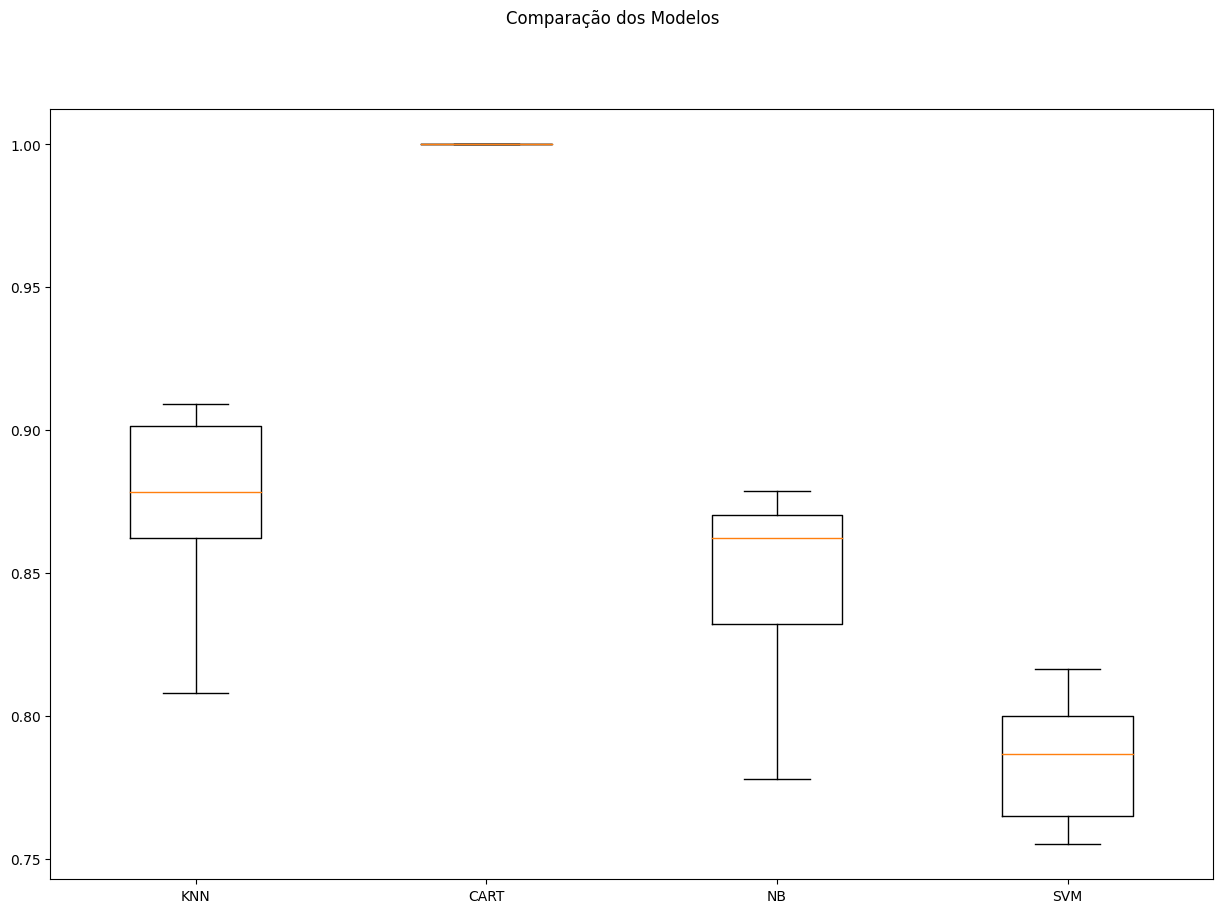

In [6]:
np.random.seed(8) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.874 (0.032)
CART-orig: 1.000 (0.000)
NB-orig: 0.848 (0.033)
SVM-orig: 0.784 (0.022)
KNN-padr: 0.925 (0.025)
CART-padr: 1.000 (0.000)
NB-padr: 0.924 (0.021)
SVM-padr: 0.942 (0.017)
KNN-norm: 0.895 (0.019)
CART-norm: 1.000 (0.000)
NB-norm: 0.924 (0.021)
SVM-norm: 0.891 (0.022)


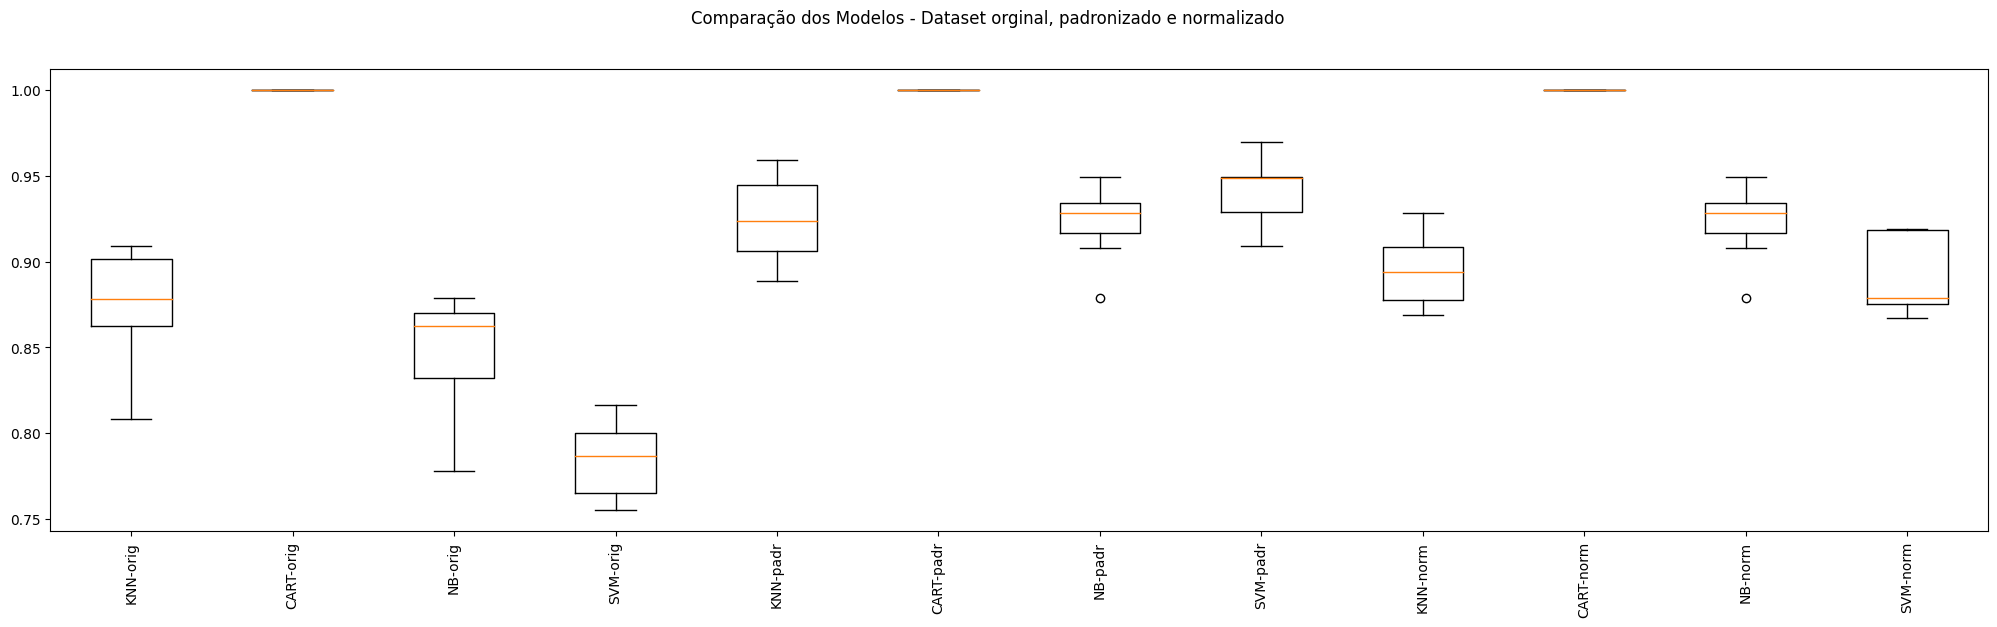

In [7]:
np.random.seed(8) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Finalização do Modelo

In [14]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier()
#DecisionTreeClassifier()
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9393939393939394


In [15]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier()

## Simulando a aplicação do modelo em dados não vistos

In [16]:
dataset.head()

,subscribers,video views,uploads,Country,Category,video_views_for_the_last_30_days,highest_monthly_earnings,Pay well
0,245000000,228000000000,20082,19,8,2258000000,9000000,1
1,166000000,28368841870,741,47,4,1348000000,5400000,1
2,162000000,164000000000,966,47,3,1975000000,7900000,1
3,159000000,148000000000,116536,19,4,1824000000,7300000,1
4,112000000,93247040539,1111,47,4,731674000,2900000,1


In [17]:
# Novos dados - não sabemos a classe!
data = {'subscribers':  [26800674545, 2733, 1961],
        'video views': [303780000, 1149000000, 1597],
         'uploads': [750, 966, 11],
        'Country': [19, 47, 19],
        'Category': [4, 3, 8],
        'video_views_for_the_last_30_days': [815949000, 528392000, 20],
        'highest_monthly_earnings': [2400000.00, 928100.00, 18.00],
        }

atributos = ['subscribers', 'video views', 'uploads', 'Country', 'Category', 'video_views_for_the_last_30_days', 'highest_monthly_earnings']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:7].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 1.62946348e+03 -7.66710420e-01 -2.48555744e-01 -8.81240257e-01
  -7.77918879e-01  1.59061742e+00  1.56683867e+00]
 [-1.37573802e+00 -7.06893877e-01 -2.42254418e-01  9.17597526e-01
  -1.13384835e+00  8.85543508e-01  2.89033411e-01]
 [-1.37578500e+00 -7.88208934e-01 -2.70114445e-01 -8.81240257e-01
   6.45799014e-01 -4.10044500e-01 -5.16665388e-01]]


In [18]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[1 1 0]


#Impantação do ML


In [19]:
# Salva o modelo no disco
filename = 'model.pkl'
dump(model, open(filename, 'wb'))